# Step 1. Getting the SEED dataset

## 1.1 load the matlab format files and take a look

In [1]:
import mne
from scipy import io
import os
import numpy as np

In [2]:
folderpath = "./Preprocessed_EEG"

In [3]:
raw_1_1 = io.loadmat('./Preprocessed_EEG/1_20131027.mat')
raw_1_2 = io.loadmat('./Preprocessed_EEG/1_20131030.mat')
raw_1_3 = io.loadmat('./Preprocessed_EEG/1_20131107.mat')
# raw_2_1 = scipy.io.loadmat('./Preprocessed_EEG/2_20140404.mat')
label = io.loadmat('./Preprocessed_EEG/label.mat')

In [4]:
raw_1_1.keys(), raw_1_2.keys(), raw_1_3.keys(), label.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'label']))

In [5]:
raw_1_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])

In [6]:
raw_1_1['djc_eeg2'].shape, raw_1_2['djc_eeg2'].shape, raw_1_1['djc_eeg10'].shape, raw_1_3['djc_eeg10'].shape

((62, 46601), (62, 46601), (62, 47401), (62, 47401))

raw_1_1['djc_eeg1']:
- raw_1_1: the raw eeg data, the 1st subject(out of 15 subjects), the 1st experiments(out of 3 experiments)
- 'djc_eeg1': djc could possibly mean the name of the subject(which leaks the privacy XD), and 'eeg1' represents it is the 1st trial(out of 15 trials)
- 62: n_channels
- 47001: roughly 4 mins(240sec * 200 Hz sampling rate) the eeg signal during watching the movies

In [7]:
label['label'][0]

array([ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1],
      dtype=int16)

## 1.2 Create the torch dataset

### 1.2.1 cut compute windows

since a movie clip contains eeg signals of ~240 seconds with sf=200Hz, I decide to cut them into 4 sec windows

In [8]:
len_window = 200 * 4

raw_X = []
raw_y = []

prefix = 'djc_eeg'

# raw_1_1
for i in range(1, 16):
    data = raw_1_1[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))

# raw_1_2
for i in range(1, 16):
    data = raw_1_2[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

# raw_1_3
for i in range(1, 16):
    data = raw_1_3[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

In [9]:
concat_X = np.concatenate(raw_X, axis=2)
print(concat_X.shape)
concat_y = np.concatenate(raw_y)
print(concat_y.shape)

(62, 800, 2526)
(2526,)


### 1.2.2 Encode the labels

In [10]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [11]:
concat_y

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)

In [12]:
le = LabelEncoder()
y = le.fit_transform(concat_y)
y = pd.get_dummies(y)
y

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2521,1,0,0
2522,1,0,0
2523,1,0,0
2524,1,0,0


one-hot encoding
- positive:  1 => [0, 0 ,1]
- neutral:   0 => [0, 1, 0]
- negative: -1 => [1, 0, 0]

In [13]:
y.shape, concat_X.shape

((2526, 3), (62, 800, 2526))

# Step 2. Create EEG-conformer model

In [14]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline

/home/pai/envs/fbc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [28]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) # input [n_batch, n_seq, n_inputsz=n_chans]
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        gru_output, _ = self.gru(x)
        flat = self.flatten(gru_output[:, -1: :])
        output = self.fc(flat)
        return output

# 定义模型输入、输出维度
input_size = 62 
hidden_size = 256
output_size = 3

# 创建模型实例
model = GRUModel(input_size, hidden_size, output_size)

# 打印模型结构
print(model)

GRUModel(
  (gru): GRU(62, 256, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [29]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)
    model.to(device)

the model will be trained on:  cuda


GRUModel(
  (gru): GRU(62, 256, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [30]:
from torchsummary import summary
summary(model, input_size=(32, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 32, 256], [-1, 2, 256]]               0
           Flatten-2                  [-1, 256]               0
            Linear-3                    [-1, 3]             771
Total params: 771
Trainable params: 771
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 32.00
Params size (MB): 0.00
Estimated Total Size (MB): 32.01
----------------------------------------------------------------


# Step 3. Training the model

## 3.1 prepare the train set / test set

In [31]:
concat_X.shape, y.shape

((62, 800, 2526), (2526, 3))

In [32]:
X = concat_X.transpose((2, 1, 0))
X.shape

(2526, 800, 62)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=777)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1768, 800, 62), (758, 800, 62), (1768, 3), (758, 3))

## 3.2 Training

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [37]:
def train(model, x_train, y_train, x_test, y_test, save_path='./model_gru/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [43]:
best_model = train(model, X_train, X_test, y_train, y_test, n_epochs=100)

the model will be trained on:  cuda


100%|██████████| 56/56 [00:01<00:00, 31.01it/s]


best_model found, best acc:  0.9868073878627969
Epoch 1/100 - Train Loss: 0.0251 - Train Accuracy: 0.9955 - Test Loss: 0.0384 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 30.73it/s]


best_model found, best acc:  0.9881266490765171
Epoch 2/100 - Train Loss: 0.0198 - Train Accuracy: 0.9983 - Test Loss: 0.0372 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.06it/s]


best_model found, best acc:  0.9894459102902374
Epoch 3/100 - Train Loss: 0.0160 - Train Accuracy: 0.9994 - Test Loss: 0.0360 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.44it/s]


best_model found, best acc:  0.9907651715039578
Epoch 4/100 - Train Loss: 0.0188 - Train Accuracy: 0.9977 - Test Loss: 0.0360 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.40it/s]


Epoch 5/100 - Train Loss: 0.0377 - Train Accuracy: 0.9887 - Test Loss: 0.0470 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.05it/s]


best_model found, best acc:  0.9920844327176781
Epoch 6/100 - Train Loss: 0.0263 - Train Accuracy: 0.9949 - Test Loss: 0.0345 - Test Accuracy: 0.9921


100%|██████████| 56/56 [00:01<00:00, 30.65it/s]


Epoch 7/100 - Train Loss: 0.0207 - Train Accuracy: 0.9960 - Test Loss: 0.0361 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.36it/s]


best_model found, best acc:  0.9934036939313984
Epoch 8/100 - Train Loss: 0.0154 - Train Accuracy: 0.9989 - Test Loss: 0.0269 - Test Accuracy: 0.9934


100%|██████████| 56/56 [00:01<00:00, 31.30it/s]


Epoch 9/100 - Train Loss: 0.0147 - Train Accuracy: 0.9989 - Test Loss: 0.0310 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 30.85it/s]


Epoch 10/100 - Train Loss: 0.0126 - Train Accuracy: 0.9983 - Test Loss: 0.0703 - Test Accuracy: 0.9749


100%|██████████| 56/56 [00:01<00:00, 30.21it/s]


Epoch 11/100 - Train Loss: 0.0280 - Train Accuracy: 0.9921 - Test Loss: 0.0600 - Test Accuracy: 0.9776


100%|██████████| 56/56 [00:01<00:00, 31.21it/s]


Epoch 12/100 - Train Loss: 0.0498 - Train Accuracy: 0.9842 - Test Loss: 0.1031 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:01<00:00, 31.06it/s]


Epoch 13/100 - Train Loss: 0.0933 - Train Accuracy: 0.9661 - Test Loss: 0.1076 - Test Accuracy: 0.9551


100%|██████████| 56/56 [00:01<00:00, 31.33it/s]


Epoch 14/100 - Train Loss: 0.0633 - Train Accuracy: 0.9796 - Test Loss: 0.0503 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.43it/s]


Epoch 15/100 - Train Loss: 0.0236 - Train Accuracy: 0.9966 - Test Loss: 0.0404 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 30.48it/s]


Epoch 16/100 - Train Loss: 0.0304 - Train Accuracy: 0.9915 - Test Loss: 0.0881 - Test Accuracy: 0.9749


100%|██████████| 56/56 [00:01<00:00, 31.18it/s]


Epoch 17/100 - Train Loss: 0.0535 - Train Accuracy: 0.9825 - Test Loss: 0.0414 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.33it/s]


Epoch 18/100 - Train Loss: 0.0208 - Train Accuracy: 0.9955 - Test Loss: 0.0330 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.12it/s]


Epoch 19/100 - Train Loss: 0.0442 - Train Accuracy: 0.9830 - Test Loss: 0.0869 - Test Accuracy: 0.9697


100%|██████████| 56/56 [00:01<00:00, 31.17it/s]


Epoch 20/100 - Train Loss: 0.0735 - Train Accuracy: 0.9717 - Test Loss: 0.1078 - Test Accuracy: 0.9617


100%|██████████| 56/56 [00:01<00:00, 30.64it/s]


Epoch 21/100 - Train Loss: 0.0801 - Train Accuracy: 0.9695 - Test Loss: 0.1242 - Test Accuracy: 0.9512


100%|██████████| 56/56 [00:01<00:00, 31.04it/s]


Epoch 22/100 - Train Loss: 0.1120 - Train Accuracy: 0.9576 - Test Loss: 0.1850 - Test Accuracy: 0.9248


100%|██████████| 56/56 [00:01<00:00, 31.44it/s]


Epoch 23/100 - Train Loss: 0.0959 - Train Accuracy: 0.9689 - Test Loss: 0.1175 - Test Accuracy: 0.9538


100%|██████████| 56/56 [00:01<00:00, 31.45it/s]


Epoch 24/100 - Train Loss: 0.1276 - Train Accuracy: 0.9525 - Test Loss: 0.1776 - Test Accuracy: 0.9406


100%|██████████| 56/56 [00:01<00:00, 30.38it/s]


Epoch 25/100 - Train Loss: 0.1394 - Train Accuracy: 0.9480 - Test Loss: 0.1529 - Test Accuracy: 0.9446


100%|██████████| 56/56 [00:01<00:00, 31.35it/s]


Epoch 26/100 - Train Loss: 0.1230 - Train Accuracy: 0.9542 - Test Loss: 0.1510 - Test Accuracy: 0.9340


100%|██████████| 56/56 [00:01<00:00, 31.31it/s]


Epoch 27/100 - Train Loss: 0.1246 - Train Accuracy: 0.9519 - Test Loss: 0.1403 - Test Accuracy: 0.9538


100%|██████████| 56/56 [00:01<00:00, 31.12it/s]


Epoch 28/100 - Train Loss: 0.1015 - Train Accuracy: 0.9627 - Test Loss: 0.1159 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:01<00:00, 31.34it/s]


Epoch 29/100 - Train Loss: 0.1034 - Train Accuracy: 0.9621 - Test Loss: 0.1034 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:01<00:00, 29.57it/s]


Epoch 30/100 - Train Loss: 0.0915 - Train Accuracy: 0.9638 - Test Loss: 0.0867 - Test Accuracy: 0.9670


100%|██████████| 56/56 [00:01<00:00, 31.48it/s]


Epoch 31/100 - Train Loss: 0.0739 - Train Accuracy: 0.9695 - Test Loss: 0.0936 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:01<00:00, 31.36it/s]


Epoch 32/100 - Train Loss: 0.0651 - Train Accuracy: 0.9745 - Test Loss: 0.1016 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:01<00:00, 31.43it/s]


Epoch 33/100 - Train Loss: 0.0583 - Train Accuracy: 0.9785 - Test Loss: 0.0822 - Test Accuracy: 0.9697


100%|██████████| 56/56 [00:01<00:00, 31.06it/s]


Epoch 34/100 - Train Loss: 0.0738 - Train Accuracy: 0.9740 - Test Loss: 0.1377 - Test Accuracy: 0.9485


100%|██████████| 56/56 [00:01<00:00, 31.11it/s]


Epoch 35/100 - Train Loss: 0.0744 - Train Accuracy: 0.9729 - Test Loss: 0.0796 - Test Accuracy: 0.9683


100%|██████████| 56/56 [00:01<00:00, 31.14it/s]


Epoch 36/100 - Train Loss: 0.0462 - Train Accuracy: 0.9819 - Test Loss: 0.0692 - Test Accuracy: 0.9763


100%|██████████| 56/56 [00:01<00:00, 31.49it/s]


Epoch 37/100 - Train Loss: 0.0450 - Train Accuracy: 0.9853 - Test Loss: 0.0614 - Test Accuracy: 0.9749


100%|██████████| 56/56 [00:01<00:00, 31.10it/s]


Epoch 38/100 - Train Loss: 0.0363 - Train Accuracy: 0.9881 - Test Loss: 0.0673 - Test Accuracy: 0.9749


100%|██████████| 56/56 [00:01<00:00, 30.53it/s]


Epoch 39/100 - Train Loss: 0.0387 - Train Accuracy: 0.9893 - Test Loss: 0.0550 - Test Accuracy: 0.9828


100%|██████████| 56/56 [00:01<00:00, 31.10it/s]


Epoch 40/100 - Train Loss: 0.0392 - Train Accuracy: 0.9898 - Test Loss: 0.0798 - Test Accuracy: 0.9749


100%|██████████| 56/56 [00:01<00:00, 30.88it/s]


Epoch 41/100 - Train Loss: 0.0362 - Train Accuracy: 0.9881 - Test Loss: 0.0616 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 31.16it/s]


Epoch 42/100 - Train Loss: 0.0352 - Train Accuracy: 0.9910 - Test Loss: 0.0644 - Test Accuracy: 0.9815


100%|██████████| 56/56 [00:01<00:00, 31.03it/s]


Epoch 43/100 - Train Loss: 0.0373 - Train Accuracy: 0.9876 - Test Loss: 0.0551 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 29.47it/s]


Epoch 44/100 - Train Loss: 0.0268 - Train Accuracy: 0.9938 - Test Loss: 0.0516 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 31.33it/s]


Epoch 45/100 - Train Loss: 0.0254 - Train Accuracy: 0.9966 - Test Loss: 0.0460 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.30it/s]


Epoch 46/100 - Train Loss: 0.0231 - Train Accuracy: 0.9955 - Test Loss: 0.0467 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.13it/s]


Epoch 47/100 - Train Loss: 0.0314 - Train Accuracy: 0.9904 - Test Loss: 0.0667 - Test Accuracy: 0.9776


100%|██████████| 56/56 [00:01<00:00, 30.76it/s]


Epoch 48/100 - Train Loss: 0.0361 - Train Accuracy: 0.9870 - Test Loss: 0.0540 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 30.96it/s]


Epoch 49/100 - Train Loss: 0.0215 - Train Accuracy: 0.9943 - Test Loss: 0.0470 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 30.98it/s]


Epoch 50/100 - Train Loss: 0.0230 - Train Accuracy: 0.9932 - Test Loss: 0.0631 - Test Accuracy: 0.9763


100%|██████████| 56/56 [00:01<00:00, 31.21it/s]


Epoch 51/100 - Train Loss: 0.0208 - Train Accuracy: 0.9972 - Test Loss: 0.0276 - Test Accuracy: 0.9934


100%|██████████| 56/56 [00:01<00:00, 31.16it/s]


Epoch 52/100 - Train Loss: 0.0404 - Train Accuracy: 0.9870 - Test Loss: 0.0902 - Test Accuracy: 0.9670


100%|██████████| 56/56 [00:01<00:00, 29.39it/s]


Epoch 53/100 - Train Loss: 0.0445 - Train Accuracy: 0.9864 - Test Loss: 0.0554 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 31.26it/s]


Epoch 54/100 - Train Loss: 0.0233 - Train Accuracy: 0.9949 - Test Loss: 0.0533 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 31.15it/s]


Epoch 55/100 - Train Loss: 0.0235 - Train Accuracy: 0.9938 - Test Loss: 0.0449 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.36it/s]


Epoch 56/100 - Train Loss: 0.0185 - Train Accuracy: 0.9977 - Test Loss: 0.0356 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.26it/s]


Epoch 57/100 - Train Loss: 0.0129 - Train Accuracy: 0.9983 - Test Loss: 0.0435 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 30.83it/s]


Epoch 58/100 - Train Loss: 0.0117 - Train Accuracy: 0.9977 - Test Loss: 0.0394 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.32it/s]


Epoch 59/100 - Train Loss: 0.0108 - Train Accuracy: 0.9983 - Test Loss: 0.0380 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.28it/s]


Epoch 60/100 - Train Loss: 0.0098 - Train Accuracy: 0.9989 - Test Loss: 0.0396 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.17it/s]


Epoch 61/100 - Train Loss: 0.0098 - Train Accuracy: 0.9983 - Test Loss: 0.0370 - Test Accuracy: 0.9921


100%|██████████| 56/56 [00:01<00:00, 30.83it/s]


Epoch 62/100 - Train Loss: 0.0110 - Train Accuracy: 0.9977 - Test Loss: 0.0559 - Test Accuracy: 0.9842


100%|██████████| 56/56 [00:01<00:00, 30.90it/s]


Epoch 63/100 - Train Loss: 0.0297 - Train Accuracy: 0.9898 - Test Loss: 0.0433 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 30.99it/s]


Epoch 64/100 - Train Loss: 0.0234 - Train Accuracy: 0.9938 - Test Loss: 0.0407 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.44it/s]


Epoch 65/100 - Train Loss: 0.0281 - Train Accuracy: 0.9949 - Test Loss: 0.0431 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.20it/s]


Epoch 66/100 - Train Loss: 0.0366 - Train Accuracy: 0.9904 - Test Loss: 0.0618 - Test Accuracy: 0.9855


100%|██████████| 56/56 [00:01<00:00, 30.60it/s]


Epoch 67/100 - Train Loss: 0.0673 - Train Accuracy: 0.9796 - Test Loss: 0.0638 - Test Accuracy: 0.9776


100%|██████████| 56/56 [00:01<00:00, 31.25it/s]


Epoch 68/100 - Train Loss: 0.0504 - Train Accuracy: 0.9819 - Test Loss: 0.0675 - Test Accuracy: 0.9736


100%|██████████| 56/56 [00:01<00:00, 31.16it/s]


Epoch 69/100 - Train Loss: 0.0421 - Train Accuracy: 0.9825 - Test Loss: 0.0612 - Test Accuracy: 0.9828


100%|██████████| 56/56 [00:01<00:00, 31.17it/s]


Epoch 70/100 - Train Loss: 0.0414 - Train Accuracy: 0.9842 - Test Loss: 0.0691 - Test Accuracy: 0.9802


100%|██████████| 56/56 [00:01<00:00, 31.01it/s]


Epoch 71/100 - Train Loss: 0.0296 - Train Accuracy: 0.9921 - Test Loss: 0.0542 - Test Accuracy: 0.9828


100%|██████████| 56/56 [00:01<00:00, 30.65it/s]


Epoch 72/100 - Train Loss: 0.0180 - Train Accuracy: 0.9960 - Test Loss: 0.0539 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 31.24it/s]


Epoch 73/100 - Train Loss: 0.0219 - Train Accuracy: 0.9932 - Test Loss: 0.0500 - Test Accuracy: 0.9855


100%|██████████| 56/56 [00:01<00:00, 31.29it/s]


Epoch 74/100 - Train Loss: 0.0199 - Train Accuracy: 0.9943 - Test Loss: 0.0412 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.17it/s]


Epoch 75/100 - Train Loss: 0.0231 - Train Accuracy: 0.9932 - Test Loss: 0.0407 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.18it/s]


Epoch 76/100 - Train Loss: 0.0159 - Train Accuracy: 0.9977 - Test Loss: 0.0381 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.28it/s]


Epoch 77/100 - Train Loss: 0.0179 - Train Accuracy: 0.9972 - Test Loss: 0.0432 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 31.15it/s]


Epoch 78/100 - Train Loss: 0.0127 - Train Accuracy: 0.9972 - Test Loss: 0.0328 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.29it/s]


Epoch 79/100 - Train Loss: 0.0120 - Train Accuracy: 0.9972 - Test Loss: 0.0378 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 31.24it/s]


Epoch 80/100 - Train Loss: 0.0126 - Train Accuracy: 0.9955 - Test Loss: 0.0389 - Test Accuracy: 0.9908


100%|██████████| 56/56 [00:01<00:00, 30.57it/s]


Epoch 81/100 - Train Loss: 0.0110 - Train Accuracy: 0.9983 - Test Loss: 0.0511 - Test Accuracy: 0.9855


100%|██████████| 56/56 [00:01<00:00, 31.25it/s]


Epoch 82/100 - Train Loss: 0.0148 - Train Accuracy: 0.9949 - Test Loss: 0.0380 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 31.35it/s]


Epoch 83/100 - Train Loss: 0.0080 - Train Accuracy: 0.9989 - Test Loss: 0.0341 - Test Accuracy: 0.9934


100%|██████████| 56/56 [00:01<00:00, 31.38it/s]


Epoch 84/100 - Train Loss: 0.0076 - Train Accuracy: 0.9994 - Test Loss: 0.0397 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 30.73it/s]


Epoch 85/100 - Train Loss: 0.0081 - Train Accuracy: 0.9994 - Test Loss: 0.0422 - Test Accuracy: 0.9894


100%|██████████| 56/56 [00:01<00:00, 30.63it/s]


Epoch 86/100 - Train Loss: 0.0075 - Train Accuracy: 0.9989 - Test Loss: 0.0438 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.17it/s]


Epoch 87/100 - Train Loss: 0.0102 - Train Accuracy: 0.9977 - Test Loss: 0.0443 - Test Accuracy: 0.9868


100%|██████████| 56/56 [00:01<00:00, 31.04it/s]


Epoch 88/100 - Train Loss: 0.0145 - Train Accuracy: 0.9977 - Test Loss: 0.0917 - Test Accuracy: 0.9763


100%|██████████| 56/56 [00:01<00:00, 30.34it/s]


Epoch 89/100 - Train Loss: 0.0150 - Train Accuracy: 0.9955 - Test Loss: 0.0474 - Test Accuracy: 0.9855


100%|██████████| 56/56 [00:01<00:00, 30.08it/s]


Epoch 90/100 - Train Loss: 0.0159 - Train Accuracy: 0.9983 - Test Loss: 0.0509 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 31.23it/s]


Epoch 91/100 - Train Loss: 0.0136 - Train Accuracy: 0.9960 - Test Loss: 0.0568 - Test Accuracy: 0.9828


100%|██████████| 56/56 [00:01<00:00, 31.21it/s]


Epoch 92/100 - Train Loss: 0.0293 - Train Accuracy: 0.9898 - Test Loss: 0.0581 - Test Accuracy: 0.9789


100%|██████████| 56/56 [00:01<00:00, 30.60it/s]


Epoch 93/100 - Train Loss: 0.0179 - Train Accuracy: 0.9960 - Test Loss: 0.0717 - Test Accuracy: 0.9776


100%|██████████| 56/56 [00:01<00:00, 30.97it/s]


Epoch 94/100 - Train Loss: 0.0186 - Train Accuracy: 0.9955 - Test Loss: 0.0660 - Test Accuracy: 0.9763


100%|██████████| 56/56 [00:01<00:00, 30.04it/s]


Epoch 95/100 - Train Loss: 0.0452 - Train Accuracy: 0.9836 - Test Loss: 0.1087 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:01<00:00, 31.21it/s]


Epoch 96/100 - Train Loss: 0.0708 - Train Accuracy: 0.9666 - Test Loss: 0.1570 - Test Accuracy: 0.9367


100%|██████████| 56/56 [00:01<00:00, 31.24it/s]


Epoch 97/100 - Train Loss: 0.0466 - Train Accuracy: 0.9830 - Test Loss: 0.0610 - Test Accuracy: 0.9789


100%|██████████| 56/56 [00:01<00:00, 30.86it/s]


Epoch 98/100 - Train Loss: 0.0174 - Train Accuracy: 0.9960 - Test Loss: 0.0539 - Test Accuracy: 0.9828


100%|██████████| 56/56 [00:01<00:00, 31.14it/s]


Epoch 99/100 - Train Loss: 0.0154 - Train Accuracy: 0.9977 - Test Loss: 0.0474 - Test Accuracy: 0.9855


100%|██████████| 56/56 [00:01<00:00, 30.78it/s]


Epoch 100/100 - Train Loss: 0.0148 - Train Accuracy: 0.9972 - Test Loss: 0.0499 - Test Accuracy: 0.9855


# Step 4. Assessment

## 4.1 Training plot

In [44]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

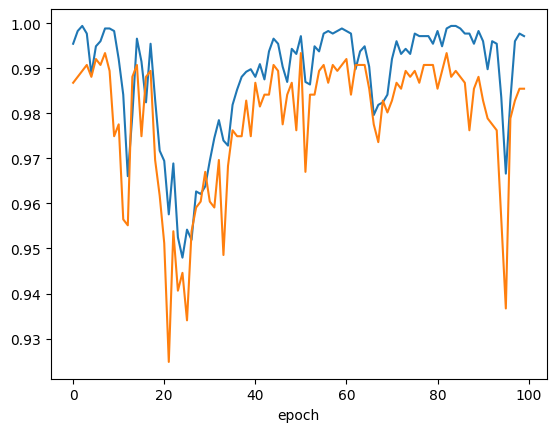

In [46]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

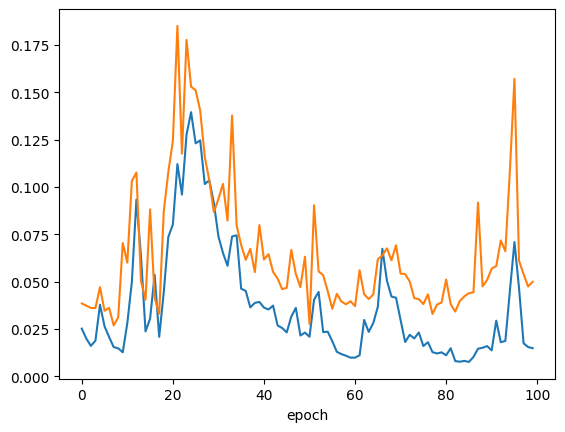

In [47]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [48]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9934


: 